In [7]:
import json
from pycocotools.coco import COCO

# Load COCO JSON
with open("train_gt.json", "r") as f:
    data = json.load(f)

# Initialize COCO API
coco = COCO("train_gt.json")

# Load categories
categories = coco.loadCats(coco.getCatIds())
category_ids = [cat["id"] for cat in categories]
print(f"✅ Categories: {category_ids}")

# Load image IDs
image_ids = coco.getImgIds()
print(f"✅ Total Images: {len(image_ids)}")

# Load annotations
annotation_ids = coco.getAnnIds()
print(f"✅ Total Annotations: {len(annotation_ids)}")


loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
✅ Categories: [0, 1]
✅ Total Images: 4970
✅ Total Annotations: 24559


In [8]:
invalid_bboxes = []
for ann in coco.loadAnns(coco.getAnnIds()):
    x, y, w, h = ann["bbox"]
    if w <= 0 or h <= 0:
        invalid_bboxes.append(ann["id"])

if invalid_bboxes:
    print(f"❌ Invalid bounding boxes in annotations: {invalid_bboxes}")
else:
    print("✅ All bounding boxes are valid!")


✅ All bounding boxes are valid!


In [9]:
area_mismatches = []
for ann in coco.loadAnns(coco.getAnnIds()):
    x, y, w, h = ann["bbox"]
    expected_area = w * h
    if abs(expected_area - ann["area"]) > 1:  # Allow slight floating point differences
        area_mismatches.append(ann["id"])

if area_mismatches:
    print(f"❌ Area mismatch in annotations: {area_mismatches}")
else:
    print("✅ All areas are correctly calculated!")


✅ All areas are correctly calculated!


In [10]:
segmentation_issues = []
for ann in coco.loadAnns(coco.getAnnIds()):
    if "segmentation" in ann and "size" in ann["segmentation"]:
        img_info = coco.loadImgs(ann["image_id"])[0]
        img_height, img_width = img_info["height"], img_info["width"]
        seg_height, seg_width = ann["segmentation"]["size"]
        if (seg_height, seg_width) != (img_height, img_width):
            segmentation_issues.append(ann["id"])

if segmentation_issues:
    print(f"❌ Segmentation size mismatch in annotations: {segmentation_issues}")
else:
    print("✅ All segmentations match image sizes!")


✅ All segmentations match image sizes!


In [11]:
fixed_annotations = []
for ann in data["annotations"]:
    # Fix invalid bounding boxes
    x, y, w, h = ann["bbox"]
    if w <= 0 or h <= 0:
        print(f"Fixing bbox {ann['id']}: {ann['bbox']}")
        ann["bbox"][2] = max(1, w)  # Ensure width > 0
        ann["bbox"][3] = max(1, h)  # Ensure height > 0

    # Fix area calculation
    ann["area"] = ann["bbox"][2] * ann["bbox"][3]

    fixed_annotations.append(ann)

# Save fixed annotations
data["annotations"] = fixed_annotations
with open("fixed_annotations.json", "w") as f:
    json.dump(data, f, indent=4)

print("✅ Fixed annotations saved as 'fixed_annotations.json'")


✅ Fixed annotations saved as 'fixed_annotations.json'


In [14]:
import json
import numpy as np
import cv2
from pycocotools import mask as mask_util

def rle_to_polygon(rle_mask):
    """Convert RLE to polygon format."""
    binary_mask = mask_util.decode(rle_mask)  # Decode RLE to a binary mask
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours:
        contour = contour.flatten().tolist()  # Convert to a list
        if len(contour) >= 6:  # Ensure valid polygon
            polygons.append(contour)

    return polygons if polygons else [[]]  # Return empty list if no valid polygons

# Load your dataset JSON
with open("train_gt.json", "r") as f:
    dataset = json.load(f)

# Convert segmentations
for annotation in dataset["annotations"]:
    if isinstance(annotation["segmentation"], dict) and "counts" in annotation["segmentation"]:
        annotation["segmentation"] = rle_to_polygon(annotation["segmentation"])

# Save the modified dataset
with open("converted_dataset.json", "w") as f:
    json.dump(dataset, f, indent=4)

print("Conversion complete! Saved as 'converted_dataset.json'.")


Conversion complete! Saved as 'converted_dataset.json'.


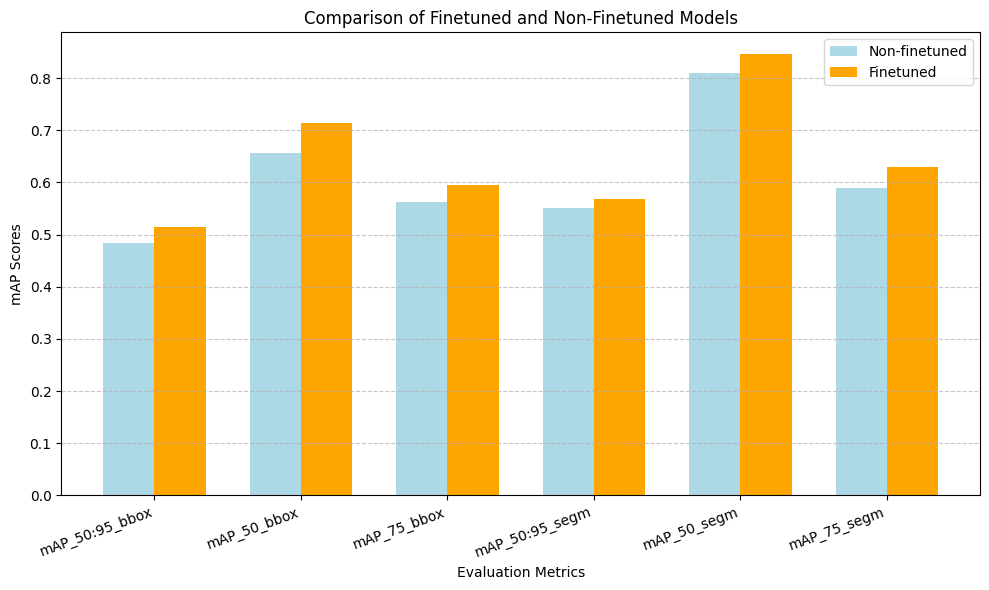

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Non-finetuned model results
non_finetuned = {
    "mAP_50:95_bbox": 0.4838,
    "mAP_50_bbox": 0.6571,
    "mAP_75_bbox": 0.5623,
    "mAP_50:95_segm": 0.5501,
    "mAP_50_segm": 0.8101,
    "mAP_75_segm": 0.5898,
}

# Finetuned model results
finetuned = {
    "mAP_50:95_bbox": 0.5144,
    "mAP_50_bbox": 0.7143,
    "mAP_75_bbox": 0.5948,
    "mAP_50:95_segm": 0.5681,
    "mAP_50_segm": 0.8454,
    "mAP_75_segm": 0.6303,
}

# Categories for plotting
categories = list(non_finetuned.keys())
x = np.arange(len(categories))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, non_finetuned.values(), width, label="Non-finetuned", color='lightblue')
ax.bar(x + width/2, finetuned.values(), width, label="Finetuned", color='orange')

# Labels, title, and legend
ax.set_xlabel("Evaluation Metrics")
ax.set_ylabel("mAP Scores")
ax.set_title("Comparison of Finetuned and Non-Finetuned Models")
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=20, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display plot
plt.tight_layout()
plt.show()
